In [3]:
#imports

import numpy as np
from astropy.table import QTable
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline


In [2]:
# reads in the initial conditions for each sim
# IC_table.csv is saved in the everything.ipynb, generated after executing the entire notebook

ic = QTable.read('IC_table_eqorb.csv',format='ascii.csv')
sim_idx = ic['Sim #']
dMass_b = ic['Mass_b']
dMass_c = ic['Mass_c']
dRadius_b = ic['Radius_b']
dRadius_c = ic['Radius_c']
dSemi_b = ic['Semi_b_0']
dSemi_c = ic['Semi_c_0']
dEcc_b = ic['Ecc_b_0']
dEcc_c = ic['Ecc_c_0']
dInc_b = ic['Incl_b_0']
dInc_c = ic['Incl_c_0']
dLongA_b = ic['LongA_b_0']
dLongA_c = ic['LongA_c_0']
dArgP_b = ic['ArgP_b_0']
dArgP_c = ic['ArgP_c_0']
dTidalQ_b = ic['Qp_b']
dTidalQ_c = ic['Qp_c']
dTidalQ_star = ic['Q_star']
dMass_star = ic['Mass_star']
dRadius_star = ic['Radius_star']

In [6]:
#dMass_b

In [4]:
#pulls final data

wd = '/home/dm1681/Research/Research/Merging_Perts'
comp_eq_only_dir = wd+'/runs_eq_only/'
comp_eqorb_dir = wd+'/runs_eqorb/'

# this script fills the below arrays for 'n' simulations
eq_sim_num = np.array([])
eq_time_final = np.array([])
eq_semi_final = np.array([])
eq_ecc_final = np.array([])

eqorb_sim_num = np.array([])
eqorb_time_final = np.array([])
eqorb_semi_final = np.array([])
eqorb_ecc_final = np.array([])

ecc_diff = np.array([]) #difference in eccentricities
semi_diff = np.array([])

eq_merged = np.array([])
eqorb_merged = np.array([])


n = 25000
t = 0
while t <= n-1:
    #extract eq_only data first:
    folder_name = '%05i'%t
    eq_folder_dir = comp_eq_only_dir+folder_name
    screen_output = open(eq_folder_dir+'/log')
    screen_content =  screen_output.read()
    screen_content = screen_content.split('\n')
    merge_line = screen_content[-4]
    if merge_line[:15] == "HALT: Merge at ":
        eq_merged = np.append(eq_merged,1)
    else:
        eq_merged = np.append(eq_merged,0)
    #Tracer()()
    b_fwd = open(eq_folder_dir+'/system.b.forward') #fwd file
    b_fwd_content = b_fwd.read()
    b_fwd_content = b_fwd_content.split('\n')
    b_fwd_lastline = b_fwd_content[-2] # last line
    b_fwd_lastline = b_fwd_lastline.split(' ')
    final_time_eq = b_fwd_lastline[0]
    final_semi_eq = b_fwd_lastline[1]
    final_ecc_eq = b_fwd_lastline[2]
    eq_time_final = np.append(eq_time_final,float(final_time_eq))
    eq_semi_final = np.append(eq_semi_final,float(final_semi_eq))
    eq_ecc_final = np.append(eq_ecc_final,float(final_ecc_eq))
    eq_sim_num = np.append(eq_sim_num,folder_name)
    
    
    #extract eqorb data last
    eqorb_folder_dir = comp_eqorb_dir+folder_name
    screen_output = open(eqorb_folder_dir+'/log')
    log = eqorb_folder_dir + '/system.log'
    if os.path.isfile(log) == True: #log file exists
        log_file = open(log)
        log_content = log_file.read()
        log_content = log_content.split('\n') #separates by line
        runtime = log_content[-2] #takes the line corresponding to "Runtime"

        if runtime[0:7] == 'Runtime': #runtime is printed
            #read in screen output to test for merge
            screen_content =  screen_output.read()
            screen_content = screen_content.split('\n')
            merge_line = screen_content[-4]
            if merge_line[:15] == "HALT: Merge at ":
                eqorb_merged = np.append(eqorb_merged,1)
            else:
                eqorb_merged = np.append(eqorb_merged,0)
                
                
            b_fwd = open(eqorb_folder_dir+'/system.b.forward')
            b_fwd_content = b_fwd.read()
            b_fwd_content = b_fwd_content.split('\n')
            b_fwd_lastline = b_fwd_content[-2]
            b_fwd_lastline = b_fwd_lastline.split(' ')
            final_time_eqorb = b_fwd_lastline[0]
            final_semi_eqorb = b_fwd_lastline[1]
            final_ecc_eqorb = b_fwd_lastline[2]
            eqorb_time_final = np.append(eqorb_time_final,float(final_time_eqorb))
            eqorb_semi_final = np.append(eqorb_semi_final,float(final_semi_eqorb))
            eqorb_ecc_final = np.append(eqorb_ecc_final,float(final_ecc_eqorb))
            eqorb_sim_num = np.append(eqorb_sim_num,folder_name)

            #some analysis:
            #difference between eccentricities:
            diff_ecc = float(final_ecc_eq) - float(final_ecc_eqorb) #if positive, eqtide > eqorb, if negative eqtide < eqorb
            diff_semi = float(final_semi_eq) - float(final_semi_eqorb)
            ecc_diff = np.append(ecc_diff,diff_ecc)
            semi_diff = np.append(semi_diff,diff_semi)
        # sets unfinished runs to -9999 to be filtered out later. 
        else:
            final_time_eqorb = -9999
            eqorb_time_final = np.append(eqorb_time_final,final_time_eqorb)

    

    t += 1
'''    
# saves the above values in a table    
final = QTable()
final['Eq_age'] = eq_time_final
final['Eqorb_age'] = eqorb_time_final
final['Eq_semi'] = eq_semi_final
final['Eqorb_semi'] = eqorb_semi_final
final['Eq_ecc'] = eq_ecc_final
final['Eqorb_ecc'] = eqorb_ecc_final
final['Diff_ecc'] = ecc_diff
final['Diff_semi'] = semi_diff
final['Sim #'] = eqorb_sim_num
final.write('final.data',format='ascii.csv')
'''

"    \n# saves the above values in a table    \nfinal = QTable()\nfinal['Eq_age'] = eq_time_final\nfinal['Eqorb_age'] = eqorb_time_final\nfinal['Eq_semi'] = eq_semi_final\nfinal['Eqorb_semi'] = eqorb_semi_final\nfinal['Eq_ecc'] = eq_ecc_final\nfinal['Eqorb_ecc'] = eqorb_ecc_final\nfinal['Diff_ecc'] = ecc_diff\nfinal['Diff_semi'] = semi_diff\nfinal['Sim #'] = eqorb_sim_num\nfinal.write('final.data',format='ascii.csv')\n"

In [5]:
eqorb_semi_final.shape

(24921,)

In [6]:
# organize with some tables and filter out uncompleted runs
eq_final = QTable()
eq_final['Sim #'] = eq_sim_num
eq_final['age'] = eq_time_final
eq_final['semi'] = eq_semi_final
eq_final['ecc'] = eq_ecc_final
eq_final['eqorb_stats'] = eqorb_time_final
eq_final['Merged'] = eq_merged

both_exist = np.where(eq_final['eqorb_stats'] != -9999)
eqorb_uncomp = np.where(eqorb_time_final != -9999)
eq_final = eq_final[both_exist]
eqorb_time_final = eqorb_time_final[eqorb_uncomp]

eqorb_final = QTable()
eqorb_final['Sim #'] = eqorb_sim_num
eqorb_final['age'] = eqorb_time_final
eqorb_final['semi'] = eqorb_semi_final
eqorb_final['ecc'] = eqorb_ecc_final
eqorb_final['Merged'] = eqorb_merged


final = QTable()
final['Eq_age'] = eq_final['age']
final['Eqorb_age'] = eqorb_final['age']
final['Eq_semi'] = eq_final['semi']
final['Eqorb_semi'] = eqorb_final['semi']
final['Eq_ecc'] = eq_final['ecc']
final['Eqorb_ecc'] = eqorb_final['ecc']
final['Eq_Merge'] = eq_final['Merged']
final['Eqorb_Merge'] = eqorb_final['Merged']
final['Diff_ecc'] = ecc_diff
final['Diff_semi'] = semi_diff
final['Sim #'] = eq_final['Sim #']
final

Eq_age,Eqorb_age,Eq_semi,Eqorb_semi,Eq_ecc,Eqorb_ecc,Eq_Merge,Eqorb_Merge,Diff_ecc,Diff_semi,Sim #
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32
10000000000.0,10000000000.0,0.079503,0.079512,0.147025,0.12814,0.0,0.0,0.018885,-9e-06,00000
3046729000.0,2448582000.0,0.006595,0.006614,0.0,0.0,1.0,1.0,0.0,-1.9e-05,00001
10000000000.0,75987.28,0.098895,0.102591,0.09057,0.662922,0.0,0.0,-0.572352,-0.003696,00002
10000000000.0,0.0,0.124557,0.124559,0.097327,0.098326,0.0,0.0,-0.000999,-2e-06,00003
10000000000.0,0.0,0.102118,0.102364,0.033924,0.045136,0.0,0.0,-0.011212,-0.000246,00004
10000000000.0,10000000000.0,0.074943,0.073131,1.108205e-05,0.009174,0.0,0.0,-0.00916291795,0.001812,00005
10000000000.0,20133260.0,0.024989,0.005285,0.0,0.050205,0.0,1.0,-0.050205,0.019704,00006
10000000000.0,10000000000.0,0.066926,0.066955,0.197318,0.157068,0.0,0.0,0.04025,-2.9e-05,00007
10000000000.0,10000000000.0,0.121883,0.121889,0.50218,0.591892,0.0,0.0,-0.089712,-5.99999999999e-06,00008


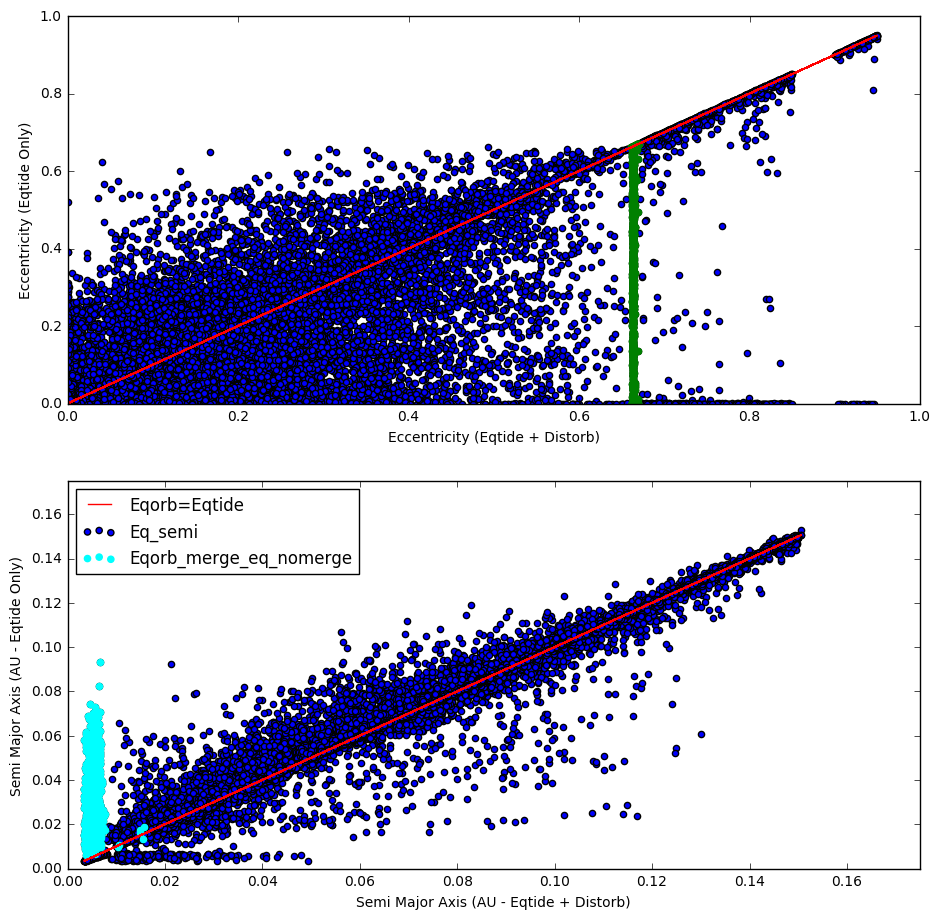

In [7]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(11,11)

#define a few masks
eqorb_greater_ecc = np.where(final['Eq_ecc']<final['Eqorb_ecc']) #Ecc of Eq < Eqorb
eq_greater_ecc = np.where(final['Eq_ecc']>final['Eqorb_ecc']) # Ecc Eq > Eqorb
eqorb_vert_line = np.where((final['Eqorb_ecc']>=0.66)&(final['Eqorb_ecc'] <= 0.67)) # the vertical line where distorb breaks
eqorb_lo_eq_hi = np.where((final['Eqorb_semi']<=0.008)&(final['Eq_semi']<=0.1)) # describes the clusters along the x and y axis below
eqorb_hi_eq_lo = np.where((final['Eqorb_semi']<=0.06)&(final['Eq_semi']<=0.01)) # describes the clusters along the x and y axis below
eqorb_merge_eqorb_nomerge = np.where((final['Eqorb_Merge'] == 1.0) & (final['Eq_Merge'] == 0.0))
both_merge = np.where((final['Eqorb_Merge'] == 1)&(final['Eq_Merge'] == 1)) 

# how many sims have completed
n = eq_final['Sim #'].shape[0]






#plots the data
ax[0].scatter(final['Eqorb_ecc'],final['Eq_ecc'])
ax[1].scatter(final['Eqorb_semi'],final['Eq_semi'])

#reference lines
ax[0].plot(final['Eqorb_ecc'],final['Eqorb_ecc'], color = 'red')
ax[1].plot(final['Eqorb_semi'],final['Eqorb_semi'], color = 'red', label='Eqorb=Eqtide')

#overlay masks
ax[0].scatter(final['Eqorb_ecc'][eqorb_vert_line],final['Eq_ecc'][eqorb_vert_line], color = 'green')
ax[1].scatter(final['Eqorb_semi'][eqorb_merge_eqorb_nomerge],final['Eq_semi'][eqorb_merge_eqorb_nomerge],color='cyan',label='Eqorb_merge_eq_nomerge')

#make it pretty
ax[0].set_ylabel('Eccentricity (Eqtide Only)')
ax[0].set_xlabel('Eccentricity (Eqtide + Distorb)')
ax[0].set_ylim(0,1)
ax[0].set_xlim(0,1)

ax[1].set_ylabel('Semi Major Axis (AU - Eqtide Only)')
ax[1].set_xlabel('Semi Major Axis (AU - Eqtide + Distorb)')
ax[1].set_ylim(0,0.175)
ax[1].set_xlim(0,0.175)
ax[1].legend(loc=0)

In [9]:
final[eqorb_merge_eqorb_nomerge]

Eq_age,Eqorb_age,Eq_semi,Eqorb_semi,Eq_ecc,Eqorb_ecc,Eq_Merge,Eqorb_Merge,Diff_ecc,Diff_semi,Sim #
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32
10000000000.0,20133260.0,0.024989,0.005285,0.0,0.050205,0.0,1.0,-0.050205,0.019704,00006
10000000000.0,257546400.0,0.051069,0.005011,0.0,0.001947,0.0,1.0,-0.001947,0.046058,00010
10000000000.0,9391295000.0,0.027441,0.005946,0.049029,3.802785e-09,0.0,1.0,0.0490289961972,0.021495,00019
10000000000.0,2424703000.0,0.01911,0.00432,0.024863,0.097943,0.0,1.0,-0.07308,0.01479,00021
10000000000.0,5978379000.0,0.021737,0.004588,0.0,0.0,0.0,1.0,0.0,0.017149,00119
10000000000.0,2945845000.0,0.033826,0.005805,0.0,0.0,0.0,1.0,0.0,0.028021,00130
10000000000.0,1981733000.0,0.037845,0.004155,0.0,0.001304,0.0,1.0,-0.001304,0.03369,00181
10000000000.0,5007305.0,0.018462,0.006052,0.0,0.04238,0.0,1.0,-0.04238,0.01241,00208
10000000000.0,1035259.0,0.017543,0.003732,0.0,0.005913,0.0,1.0,-0.005913,0.013811,00212


In [7]:
avg_diff_ecc = np.average(final['Diff_ecc'])
avg_diff_semi = np.average(final['Diff_semi'])
'''
change plots using vplot, and look at rory 2015
outline of paper!!!!!;
reproduce owen and email with new stuff--> latex
'''

-0.043319277527550104

(-0.01, 0.175)

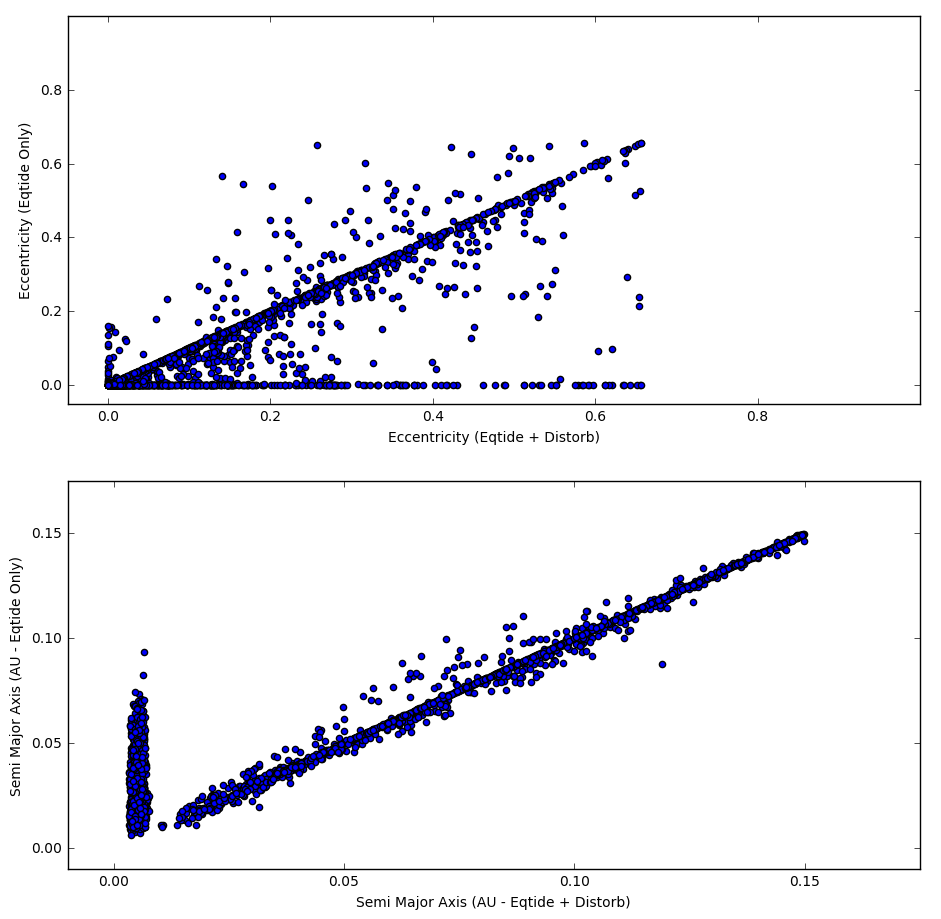

In [8]:
# I want to display which runs merged:
# The masks below will give me those runs,
# Now I just need to see which did NOT merge initially (no perturber)
# and compare to those that DID merge (with perturber)
# and plot various parameters

#final[eqorb_merge_eq_no_merge] # this is the subset of data used below

fig,ax = plt.subplots(2,1)
fig.set_size_inches(11,11)

# mask used below
eqorb_merge_eq_no_merge = np.where((final['Eqorb_age'] < 1e10) & # merged w/ perturber
                                   (final['Eq_age'] == 1e10) &  # no merge w/o perturber
                                   (final['Eqorb_ecc']<=0.66) # the limit for distorb to crash
                                  )
eq_merge = np.where(final['Eq_age']<1e10)

# ecc for eq and eqorb
ax[0].scatter(final['Eqorb_ecc'][eqorb_merge_eq_no_merge],final['Eq_ecc'][eqorb_merge_eq_no_merge])
ax[1].scatter(final['Eqorb_semi'][eqorb_merge_eq_no_merge],final['Eq_semi'][eqorb_merge_eq_no_merge])

#make it pretty
ax[0].set_ylabel('Eccentricity (Eqtide Only)')
ax[0].set_xlabel('Eccentricity (Eqtide + Distorb)')
ax[0].set_ylim(-0.05,1)
ax[0].set_xlim(-0.05,1)

ax[1].set_ylabel('Semi Major Axis (AU - Eqtide Only)')
ax[1].set_xlabel('Semi Major Axis (AU - Eqtide + Distorb)')
ax[1].set_ylim(-0.01,0.175)
ax[1].set_xlim(-0.01,0.175)

In [9]:
final[eqorb_merge_eq_no_merge]
#final[eq_merge]

Eq_age,Eqorb_age,Eq_semi,Eqorb_semi,Eq_ecc,Eqorb_ecc,Diff_ecc,Diff_semi,Sim #
float64,float64,float64,float64,float64,float64,float64,float64,str32
10000000000.0,0.0,0.124557,0.124559,0.097327,0.098326,-0.000999,-2e-06,00003
10000000000.0,0.0,0.102118,0.102364,0.033924,0.045136,-0.011212,-0.000246,00004
10000000000.0,20133260.0,0.024989,0.005285,0.0,0.050205,-0.050205,0.019704,00006
10000000000.0,257546400.0,0.051069,0.005011,0.0,0.001947,-0.001947,0.046058,00010
10000000000.0,9391295000.0,0.027441,0.005946,0.049029,3.802785e-09,0.0490289961972,0.021495,00019
10000000000.0,2424703000.0,0.01911,0.00432,0.024863,0.097943,-0.07308,0.01479,00021
10000000000.0,0.0,0.121268,0.121268,0.271556,0.269922,0.001634,0.0,00041
10000000000.0,0.0,0.146883,0.147335,0.088349,0.094602,-0.006253,-0.000452,00059
10000000000.0,0.0,0.069403,0.068288,4.636269e-06,0.270355,-0.270350363731,0.001115,00067


In [ ]:
'''
Luger et al. 2015, habitable evaporated cores

create input files with atmesc and stellar
neptume mass; mess around with vplanet
'''